In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np

# Categorical nuisance

In [2]:
from carl.distributions import Mixture, MultivariateNormal

p = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
q0 = MultivariateNormal(mu=np.array([1., -1.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([1., 3.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [3]:
from keras.utils import np_utils

n_samples = 20000

X0 = np.vstack([p.rvs(n_samples), q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])

z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2
z = np_utils.to_categorical(z.astype(np.int))

Using Theano backend.


In [4]:
X.shape, y.shape, z.shape

((120000, 2), (120000,), (120000, 3))

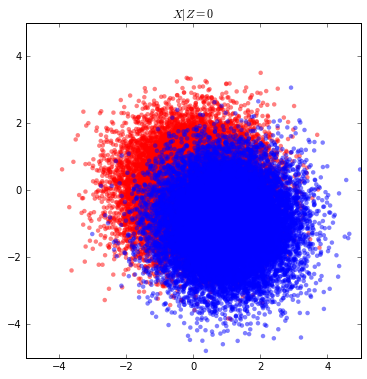

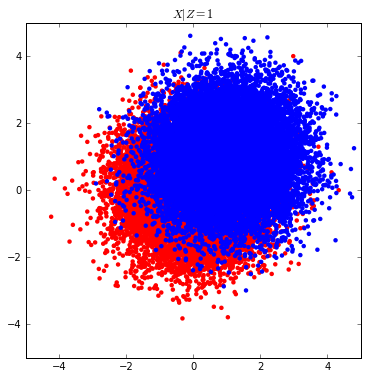

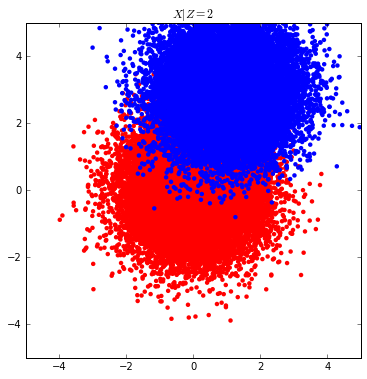

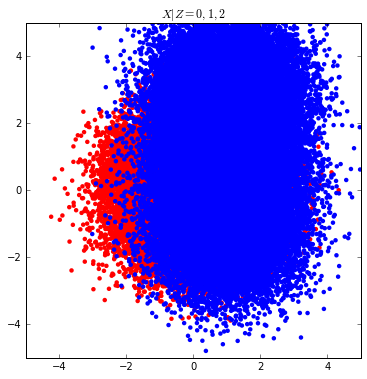

In [5]:
plt.title("$X|Z=0$")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none", alpha=0.5)
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("$X|Z=1$")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("$X|Z=2$")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("$X|Z=0,1,2$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [6]:
from scipy.stats import entropy

# when Z is marginalized out, the best classifier is p.pdf(X) / (p.pdf(X) + q_full.pdf(X)

probas = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
probas = np.hstack([probas.reshape(-1, 1), 
                    (1.-probas).reshape(-1, 1)])
min_Lf = np.mean([entropy(p_i) for p_i in probas])   # lower bound on Lf
min_Lr = entropy([1. / 3] * 3)

In [7]:
min_Lf, min_Lr

(0.47411897388562646, 1.0986122886681096)

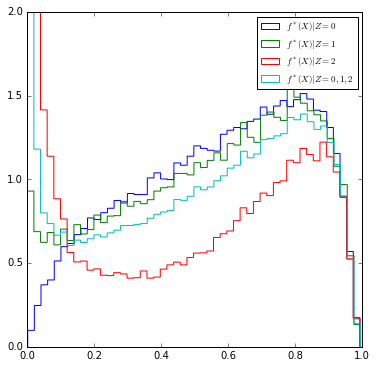

In [8]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0$", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=1$", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=2$", normed=1)
d = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0,1,2$", normed=1)
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0, 2.)
plt.show()

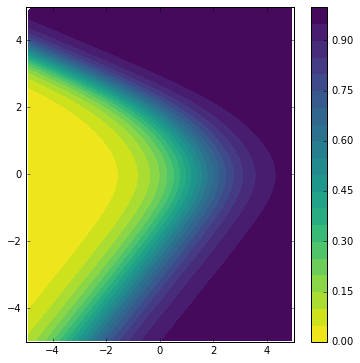

In [29]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

from matplotlib.mlab import griddata
xi = np.linspace(-5, 5., 100)
yi = np.linspace(-5, 5., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [10]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y1, q_full.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.76927911374999991,
 0.79692385500000007,
 0.97346711875000003,
 0.84674256624999999)

# Adversarial training of f

In [11]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [12]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(20, activation="tanh")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [13]:
R.predict(X_train[:3])

array([[ 0.34838268,  0.33163479,  0.31998256],
       [ 0.34838971,  0.33163381,  0.31997648],
       [ 0.34825003,  0.33165318,  0.32009679]], dtype=float32)

In [14]:
from keras.optimizers import Adam, SGD
import keras.backend as K

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_DRf = SGD() #Adam() #SGD(lr=10e-3, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD() # Adam() #SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [15]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 1)             501         input_1[0][0]                    
____________________________________________________________________________________________________
model_2 (Model)                  (None, 3)             1024        input_1[0][0]                    
Total params: 1525
____________________________________________________________________________________________________


In [16]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_2 (Model)                  (None, 3)             1024        input_1[0][0]                    
Total params: 1024
____________________________________________________________________________________________________


In [17]:
DRf.predict(X_train[:3])

[array([[ 0.64236248],
        [ 0.64265269],
        [ 0.63688529]], dtype=float32),
 array([[ 0.34838268,  0.33163479,  0.31998256],
        [ 0.34838971,  0.33163381,  0.31997648],
        [ 0.34825003,  0.33165318,  0.32009679]], dtype=float32)]

In [18]:
DfR.predict(X_train[:3])

array([[ 0.34838268,  0.33163479,  0.31998256],
       [ 0.34838971,  0.33163381,  0.31997648],
       [ 0.34825003,  0.33165318,  0.32009679]], dtype=float32)

In [19]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
115000/115000 [==============================] - 1s - loss: 1.0949     
Epoch 2/10
115000/115000 [==============================] - 1s - loss: 1.0890     
Epoch 3/10
115000/115000 [==============================] - 1s - loss: 1.0844     
Epoch 4/10
115000/115000 [==============================] - 1s - loss: 1.0824     
Epoch 5/10
115000/115000 [==============================] - 1s - loss: 1.0818     
Epoch 6/10
115000/115000 [==============================] - 1s - loss: 1.0817     
Epoch 7/10
115000/115000 [==============================] - 1s - loss: 1.0817     
Epoch 8/10
115000/115000 [==============================] - 1s - loss: 1.0816     
Epoch 9/10
115000/115000 [==============================] - 1s - loss: 1.0816     
Epoch 10/10
115000/115000 [==============================] - 1s - loss: 1.0815     


In [20]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(211)   
    plt.axhline(y=min_Lf, ls="dashed")
    plt.axhline(y=min_Lr, ls="dashed")
    
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$")
    plt.ylim(min_Lf - 0.1, min_Lr + 0.2)
    plt.legend(loc="upper right", prop={'size': 9}, ncol=2)
    
    ax2 = plt.subplot(212, sharex=ax1)
    plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right", prop={'size': 9})
    plt.show()   

In [21]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

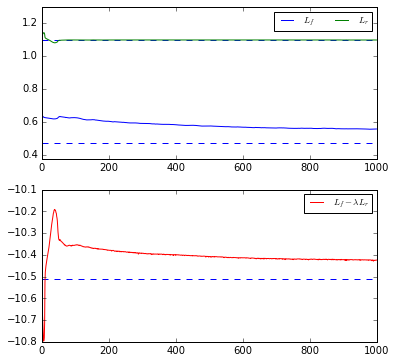

In [22]:
batch_size = 128

for i in range(1001):
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

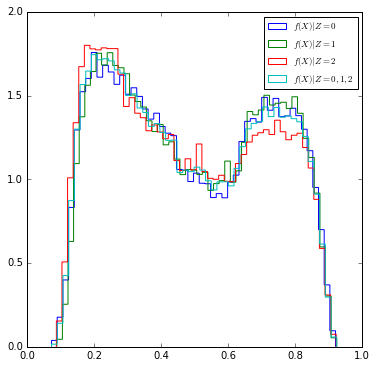

In [23]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="$f(X)|Z=0,1,2$")
plt.legend(loc="best", prop={'size': 9})
plt.ylim(0, 2.)
plt.show()

Looks pivotal!

In [24]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

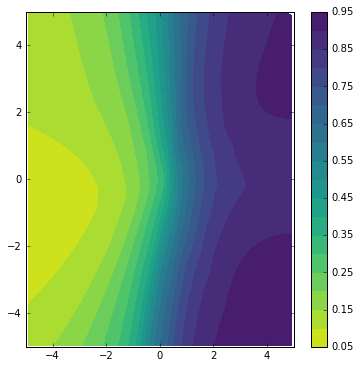

In [28]:
from matplotlib.mlab import griddata
xi = np.linspace(-5., 5., 100)
yi = np.linspace(-5., 5., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis_r,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [26]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.77403584125000013,
 0.77151068624999997,
 0.81411769499999997,
 0.78659022277777779)

In [27]:
print(min_Lr)

probas = DfR.predict(X_valid)
mean_entropy_f = np.mean([entropy(q) for q in probas])
print(mean_entropy_f)

1.09861228867
1.09785
